     trade_number          entry_time   side        entry           sl  \
0               1 2024-11-21 14:00:00  short  2662.503440  2667.262940   
1               2 2024-11-21 18:00:00   long  2673.023522  2668.264022   
2               3 2024-11-22 14:00:00  short  2696.680774  2700.991774   
3               4 2024-11-22 15:00:00   long  2704.887773  2700.576773   
4               5 2024-11-25 14:00:00  short  2679.663990  2683.541990   
..            ...                 ...    ...          ...          ...   
297           298 2025-11-20 14:00:00   long  4083.095130  4071.795130   
298           299 2025-11-20 16:00:00  short  4060.181574  4071.481574   
299           300 2025-11-24 14:00:00   long  4084.495544  4074.959044   
300           301 2025-11-25 16:00:00   long  4139.463335  4127.765835   
301           302 2025-11-26 14:00:00  short  4149.160246  4161.874246   

              tp           exit_time         exit        pnl   cum_equity  
0    2652.984440 2024-11-21 14:00:0

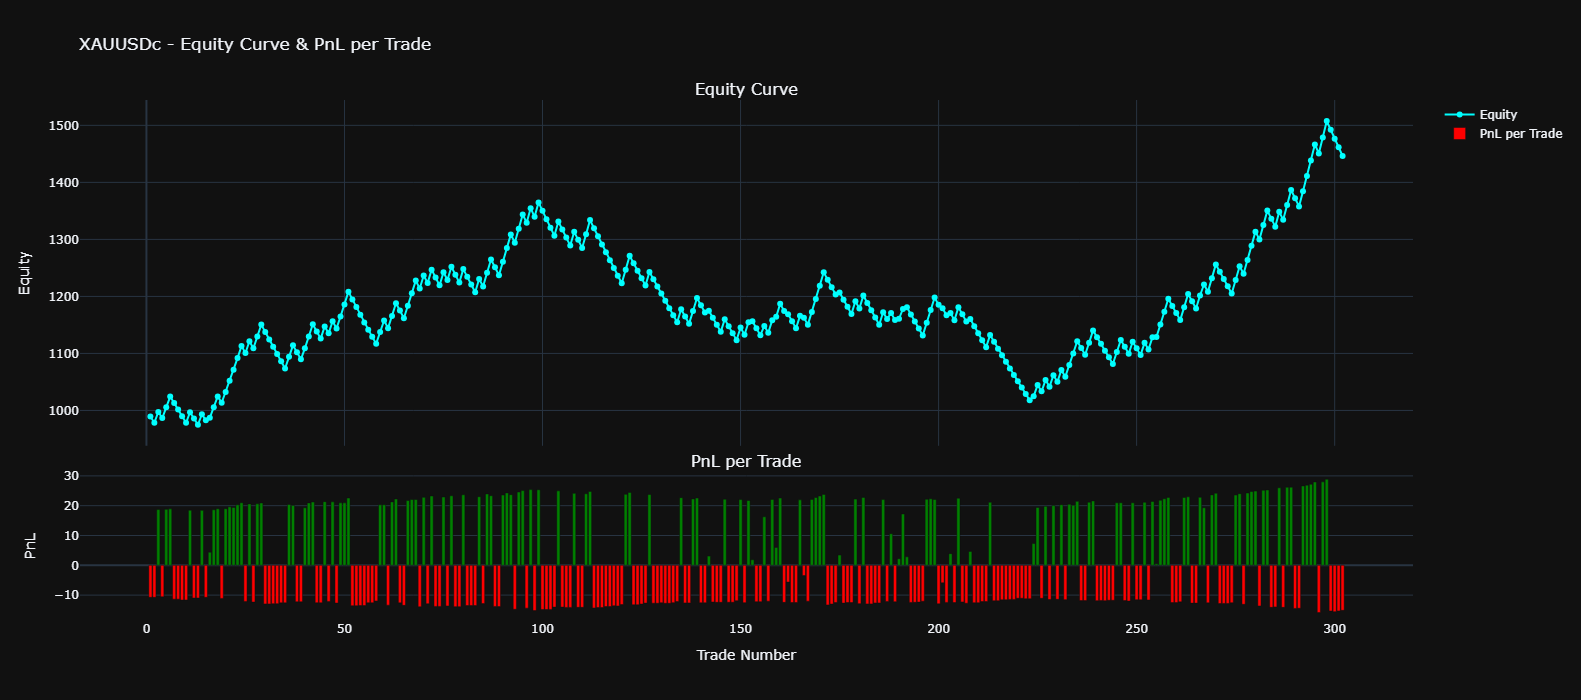

In [22]:
# -----------------------------
# STRATEGY: UTC 12→13 RANGE + REVISIT -> PLACE BOTH STOPS (Buy @High, Sell @Low)
# Backtest simulation (no live order placement)
# Slippage & Spread applied (Option B: entry, SL, TP shift together)
# -----------------------------

import MetaTrader5 as mt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta
import random

# -----------------------------
# 0. CONFIG
# -----------------------------
symbol = "XAUUSDc"
timeframe = mt.TIMEFRAME_H1
num_candles = 6000
risk_multiplier = 2.0
risk_per_trade_pct = 0.01
commission_pct = 0.01  
spread = 0.3
slippage_max = 1     
equity_start = 1000
verbose = False

# -----------------------------
# 1. CONNECT & FETCH
# -----------------------------
if not mt.initialize():
    raise RuntimeError("MT5 initialization failed")

rates = mt.copy_rates_from_pos(symbol, timeframe, 0, num_candles)
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
df.rename(columns={'open':'Open','high':'High','low':'Low','close':'Close','tick_volume':'Volume'}, inplace=True)

# -----------------------------
# 2. CALC DELTA
# -----------------------------
df['Delta'] = df.apply(lambda r: r['Volume'] if r['Close']>r['Open'] else (-r['Volume'] if r['Close']<r['Open'] else 0), axis=1)

# -----------------------------
# 3. BUILD DAILY UTC 12->13 BOXES
# -----------------------------
df_utc = df.copy()
df_utc.index = df_utc.index.tz_localize('UTC')
df_utc['Date'] = df_utc.index.date

session_boxes = []
for day, day_df in df_utc.groupby('Date'):
    session_df = day_df[(day_df.index.hour == 12)]
    if len(session_df) == 0:
        continue
    session_high = session_df['High'].max()
    session_low  = session_df['Low'].min()
    session_start = session_df.index[0]
    session_end   = session_df.index[-1]
    mid = (session_high + session_low) / 2.0
    session_boxes.append({
        'date': day,
        'start': session_start,
        'end': session_end,
        'high': session_high,
        'low': session_low,
        'mid': mid
    })

# -----------------------------
# 4. STRATEGY SIMULATION
# -----------------------------
trades = []
equity = equity_start

for box in session_boxes:

    session_end_naive = box['end'].tz_convert(None) if hasattr(box['end'], 'tzinfo') else box['end']
    try:
        start_loc = df.index.get_loc(session_end_naive)
    except KeyError:
        start_loc = df.index.searchsorted(session_end_naive)

    monitor_slice = df.iloc[start_loc+1:]
    monitor_slice = monitor_slice[monitor_slice.index.date == box['date']]
    if monitor_slice.empty:
        continue

    mid = box['mid']
    box_high = box['high']
    box_low = box['low']

    placed_pending = False
    my_pending = []

    for idx, row in monitor_slice.iterrows():

        # --- PLACE BOTH STOPS WHEN MID IS REVISITED ---
        if not placed_pending and (row['Low'] <= mid <= row['High']):
            placed_pending = True

            # Random slippage for this trade (applied to entry, SL, TP)
            slippage_buy = random.uniform(-slippage_max, slippage_max)
            slippage_sell = random.uniform(-slippage_max, slippage_max)

            # BUY STOP
            buy_entry = box_high + spread + slippage_buy
            buy_sl = mid + slippage_buy
            buy_r = abs(buy_entry - buy_sl)
            buy_tp = buy_entry + risk_multiplier * buy_r
            buy_size = (equity * risk_per_trade_pct) / buy_r

            # SELL STOP
            sell_entry = box_low - spread + slippage_sell
            sell_sl = mid + slippage_sell
            sell_r = abs(sell_entry - sell_sl)
            sell_tp = sell_entry - risk_multiplier * sell_r
            sell_size = (equity * risk_per_trade_pct) / sell_r

            my_pending = [
                {'side':'buystop', 'entry':buy_entry, 'sl':buy_sl, 'tp':buy_tp, 'size':buy_size, 'activated':False},
                {'side':'sellstop','entry':sell_entry,'sl':sell_sl,'tp':sell_tp,'size':sell_size,'activated':False}
            ]
            continue

        # -----------------------------------------
        # EXECUTE TRIGGERS (BUY STOP / SELL STOP)
        # -----------------------------------------
        for po in my_pending:
            if po['activated']:
                continue

            pos_idx = monitor_slice.index.get_loc(idx)
            exit_price = None
            exit_time = None

            # -------------------
            # BUY STOP TRIGGERED
            # -------------------
            if po['side'] == 'buystop' and row['High'] >= po['entry']:

                entry_price = po['entry']
                sl = po['sl']
                tp = po['tp']

                for j in range(pos_idx, len(monitor_slice)):
                    r2 = monitor_slice.iloc[j]

                    if r2['High'] >= tp:
                        exit_price = tp
                        exit_time = monitor_slice.index[j]
                        break

                    if r2['Low'] <= sl:
                        exit_price = sl
                        exit_time = monitor_slice.index[j]
                        break

                if exit_price is None:
                    exit_time = monitor_slice.index[-1]
                    exit_price = monitor_slice.iloc[-1]['Close']

                # ------------------------------
                # PnL with spread & commission
                pnl = (exit_price - entry_price - spread) * po['size']

                if pnl > 0:
                    pnl *= (1 - commission_pct)
                else:
                    pnl *= (1 + commission_pct)

                trades.append({
                    'entry_time':idx,'side':'long','entry':entry_price,
                    'sl':sl,'tp':tp,'exit_time':exit_time,'exit':exit_price,'pnl':pnl
                })

                po['activated'] = True
                equity += pnl

            # ---------------------
            # SELL STOP TRIGGERED
            # ---------------------
            elif po['side'] == 'sellstop' and row['Low'] <= po['entry']:

                entry_price = po['entry']
                sl = po['sl']
                tp = po['tp']

                for j in range(pos_idx, len(monitor_slice)):
                    r2 = monitor_slice.iloc[j]

                    if r2['Low'] <= tp:
                        exit_price = tp
                        exit_time = monitor_slice.index[j]
                        break

                    if r2['High'] >= sl:
                        exit_price = sl
                        exit_time = monitor_slice.index[j]
                        break

                if exit_price is None:
                    exit_time = monitor_slice.index[-1]
                    exit_price = monitor_slice.iloc[-1]['Close']

                # ------------------------------
                # PnL with spread & commission
                pnl = (entry_price - exit_price - spread) * po['size']

                if pnl > 0:
                    pnl *= (1 - commission_pct)
                else:
                    pnl *= (1 + commission_pct)

                trades.append({
                    'entry_time':idx,'side':'short','entry':entry_price,
                    'sl':sl,'tp':tp,'exit_time':exit_time,'exit':exit_price,'pnl':pnl
                })

                po['activated'] = True
                equity += pnl

        if all(po['activated'] for po in my_pending) and len(my_pending)>0:
            break

    my_pending = []
    placed_pending = False

# -----------------------------
# 5. REPORT RESULTS
# -----------------------------
trades_df = pd.DataFrame(trades)
if trades_df.empty:
    print("No trades executed in this backtest.")
else:
    trades_df['cum_equity'] = equity_start + trades_df['pnl'].cumsum()
    trades_df['trade_number'] = range(1, len(trades_df)+1)
    print(trades_df[['trade_number','entry_time','side','entry','sl','tp','exit_time','exit','pnl','cum_equity']])

# -----------------------------
# 6. EQUITY CURVE + P&L BARS
# -----------------------------
if not trades_df.empty:
    fig2 = make_subplots(rows=2, cols=1, shared_xaxes=True, row_heights=[0.7,0.3], vertical_spacing=0.05,
                         subplot_titles=("Equity Curve", "PnL per Trade"))

    fig2.add_trace(go.Scatter(x=trades_df['trade_number'], y=trades_df['cum_equity'],
                              mode='lines+markers',
                              line=dict(color='cyan', width=2),
                              name='Equity'), row=1, col=1)

    colors = ['green' if p > 0 else 'red' for p in trades_df['pnl']]
    fig2.add_trace(go.Bar(x=trades_df['trade_number'], y=trades_df['pnl'],
                          marker_color=colors, name='PnL per Trade'),
                   row=2, col=1)

    fig2.update_layout(template='plotly_dark', height=700, width=1000,
                       title_text=f"{symbol} - Equity Curve & PnL per Trade")

    fig2.update_xaxes(title_text='Trade Number', row=2, col=1)
    fig2.update_yaxes(title_text='Equity', row=1, col=1)
    fig2.update_yaxes(title_text='PnL', row=2, col=1)
    fig2.show()


Got it! We can wrap your existing backtest logic into a Monte Carlo simulation by introducing randomized slippage for each run, repeating the backtest 500 times, and then collecting the final equity or equity curves. Here's a complete revision of your code with Monte Carlo simulation integrated:

In [ ]:
# -----------------------------
# MONTE CARLO BACKTEST
# -----------------------------
import MetaTrader5 as mt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta
import random

# -----------------------------
# 0. CONFIG
# -----------------------------
symbol = "XAUUSDc"
timeframe = mt.TIMEFRAME_H1
num_candles = 6000
risk_multiplier = 2.0
risk_per_trade_pct = 0.01
commission_pct = 0.01  
spread = 0.3
slippage_max = 1     
equity_start = 1000
montecarlo_runs = 2
verbose = False

# -----------------------------
# 1. CONNECT & FETCH
# -----------------------------
if not mt.initialize():
    raise RuntimeError("MT5 initialization failed")

rates = mt.copy_rates_from_pos(symbol, timeframe, 0, num_candles)
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
df.rename(columns={'open':'Open','high':'High','low':'Low','close':'Close','tick_volume':'Volume'}, inplace=True)

# -----------------------------
# 2. CALC DELTA
# -----------------------------
df['Delta'] = df.apply(lambda r: r['Volume'] if r['Close']>r['Open'] else (-r['Volume'] if r['Close']<r['Open'] else 0), axis=1)

# -----------------------------
# 3. BUILD DAILY UTC 12->13 BOXES
# -----------------------------
df_utc = df.copy()
df_utc.index = df_utc.index.tz_localize('UTC')
df_utc['Date'] = df_utc.index.date

session_boxes = []
for day, day_df in df_utc.groupby('Date'):
    session_df = day_df[(day_df.index.hour == 12)]
    if len(session_df) == 0:
        continue
    session_high = session_df['High'].max()
    session_low  = session_df['Low'].min()
    session_start = session_df.index[0]
    session_end   = session_df.index[-1]
    mid = (session_high + session_low) / 2.0
    session_boxes.append({
        'date': day,
        'start': session_start,
        'end': session_end,
        'high': session_high,
        'low': session_low,
        'mid': mid
    })

# -----------------------------
# 4. MONTE CARLO SIMULATION
# -----------------------------
final_equities = []
all_runs_equity_curves = []

for run in range(montecarlo_runs):
    trades = []
    equity = equity_start

    for box in session_boxes:

        session_end_naive = box['end'].tz_convert(None) if hasattr(box['end'], 'tzinfo') else box['end']
        try:
            start_loc = df.index.get_loc(session_end_naive)
        except KeyError:
            start_loc = df.index.searchsorted(session_end_naive)

        monitor_slice = df.iloc[start_loc+1:]
        monitor_slice = monitor_slice[monitor_slice.index.date == box['date']]
        if monitor_slice.empty:
            continue

        mid = box['mid']
        box_high = box['high']
        box_low = box['low']

        placed_pending = False
        my_pending = []

        for idx, row in monitor_slice.iterrows():

            # --- PLACE BOTH STOPS WHEN MID IS REVISITED ---
            if not placed_pending and (row['Low'] <= mid <= row['High']):
                placed_pending = True

                # Random slippage per Monte Carlo run
                slippage_buy = random.uniform(-slippage_max, slippage_max)
                slippage_sell = random.uniform(-slippage_max, slippage_max)

                # BUY STOP
                buy_entry = box_high + spread + slippage_buy
                buy_sl = mid + slippage_buy
                buy_r = abs(buy_entry - buy_sl)
                buy_tp = buy_entry + risk_multiplier * buy_r
                buy_size = (equity * risk_per_trade_pct) / buy_r

                # SELL STOP
                sell_entry = box_low - spread + slippage_sell
                sell_sl = mid + slippage_sell
                sell_r = abs(sell_entry - sell_sl)
                sell_tp = sell_entry - risk_multiplier * sell_r
                sell_size = (equity * risk_per_trade_pct) / sell_r

                my_pending = [
                    {'side':'buystop', 'entry':buy_entry, 'sl':buy_sl, 'tp':buy_tp, 'size':buy_size, 'activated':False},
                    {'side':'sellstop','entry':sell_entry,'sl':sell_sl,'tp':sell_tp,'size':sell_size,'activated':False}
                ]
                continue

            # EXECUTE TRIGGERS
            for po in my_pending:
                if po['activated']:
                    continue

                pos_idx = monitor_slice.index.get_loc(idx)
                exit_price = None
                exit_time = None

                # BUY STOP TRIGGERED
                if po['side'] == 'buystop' and row['High'] >= po['entry']:
                    entry_price = po['entry']
                    sl = po['sl']
                    tp = po['tp']
                    for j in range(pos_idx, len(monitor_slice)):
                        r2 = monitor_slice.iloc[j]
                        if r2['High'] >= tp:
                            exit_price = tp
                            exit_time = monitor_slice.index[j]
                            break
                        if r2['Low'] <= sl:
                            exit_price = sl
                            exit_time = monitor_slice.index[j]
                            break
                    if exit_price is None:
                        exit_time = monitor_slice.index[-1]
                        exit_price = monitor_slice.iloc[-1]['Close']

                    pnl = (exit_price - entry_price - spread) * po['size']
                    pnl = pnl*(1-commission_pct) if pnl>0 else pnl*(1+commission_pct)
                    trades.append(pnl)
                    equity += pnl
                    po['activated'] = True

                # SELL STOP TRIGGERED
                elif po['side'] == 'sellstop' and row['Low'] <= po['entry']:
                    entry_price = po['entry']
                    sl = po['sl']
                    tp = po['tp']
                    for j in range(pos_idx, len(monitor_slice)):
                        r2 = monitor_slice.iloc[j]
                        if r2['Low'] <= tp:
                            exit_price = tp
                            exit_time = monitor_slice.index[j]
                            break
                        if r2['High'] >= sl:
                            exit_price = sl
                            exit_time = monitor_slice.index[j]
                            break
                    if exit_price is None:
                        exit_time = monitor_slice.index[-1]
                        exit_price = monitor_slice.iloc[-1]['Close']

                    pnl = (entry_price - exit_price - spread) * po['size']
                    pnl = pnl*(1-commission_pct) if pnl>0 else pnl*(1+commission_pct)
                    trades.append(pnl)
                    equity += pnl
                    po['activated'] = True

            if all(po['activated'] for po in my_pending) and len(my_pending)>0:
                break

        my_pending = []
        placed_pending = False

    final_equities.append(equity)
    all_runs_equity_curves.append(pd.Series(trades).cumsum() + equity_start)

# -----------------------------
# 5. REPORT MONTE CARLO RESULTS
# -----------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for eq_curve in all_runs_equity_curves:
    plt.plot(eq_curve, color='lightblue', alpha=0.2)
plt.axhline(equity_start, color='black', linestyle='--', label='Starting Equity')
plt.title(f"{symbol} - Monte Carlo Simulation ({montecarlo_runs} runs)")
plt.xlabel("Trade Number")
plt.ylabel("Equity")
plt.show()

print(f"Monte Carlo Results ({montecarlo_runs} runs):")
print(f"Mean Final Equity: {np.mean(final_equities):.2f}")
print(f"Median Final Equity: {np.median(final_equities):.2f}")
print(f"Max Final Equity: {np.max(final_equities):.2f}")
print(f"Min Final Equity: {np.min(final_equities):.2f}")
